Classification Report:

              precision    recall  f1-score   support

          -1       0.92      0.91      0.91       941
           1       0.93      0.94      0.94      1270

    accuracy                           0.93      2211
   macro avg       0.93      0.92      0.92      2211
weighted avg       0.93      0.93      0.93      2211



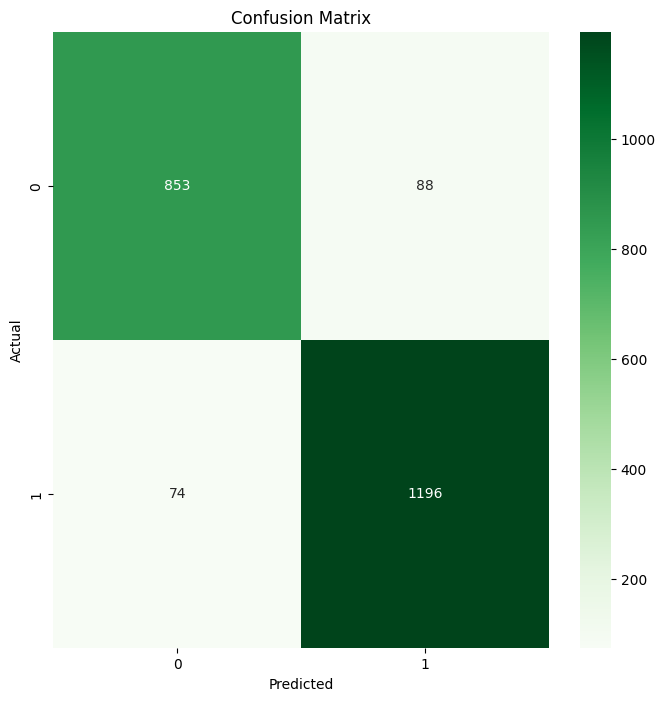

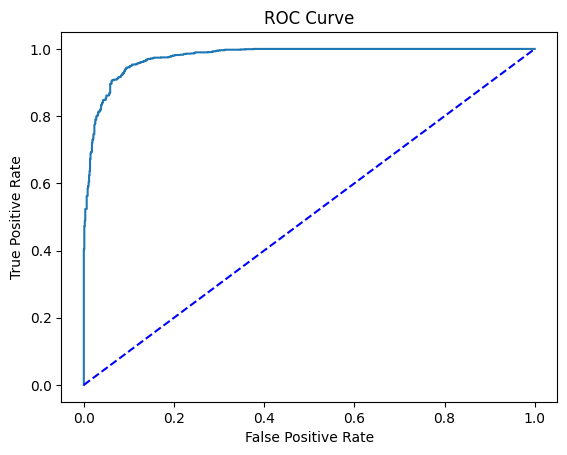

When max false positive rate is 0.15 our threshold is:  0.2941140294299335
Our actual false positive rate at this max is:  0.14771519659936239
Our best true positive rate is:  0.9716535433070866


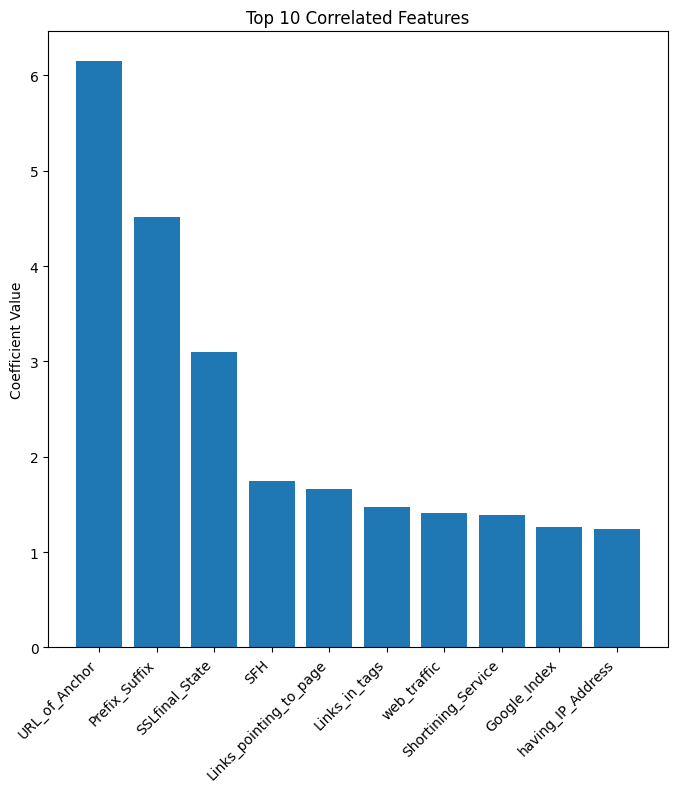

RFECV determined the best number of features is:  30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [12]:
#Identify which URL is phishing or normal, binary classifier
!pip install --upgrade scikit-learn scikeras[tensorflow]
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import RFECV
from keras import Sequential, regularizers
from keras.layers import Dense, Input, Dropout
from keras.models import load_model




#import data since it's a arff file have to convert it to a dataframe

data, features = arff.loadarff("/content/Training Dataset.arff")
url = data.tolist()
df = pd.DataFrame(url, columns = features.names())

#checking for bytes objects and turning them into strings so code works, iterate through each column and value
for column in df.columns:
  fixed = []
  for value in df[column]:
    # if bytes then fix
    if type(value) == bytes:
      fixed.append(value.decode())
    else:
      fixed.append(value)
  df[column] = fixed

#drop missing values
df = df.dropna()
df.head()


#prepare features and labels
X = df.drop('Result', axis=1).astype(float)
y = df['Result'].astype(int)


#normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


#train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=55)

#logistic regression model pre feature processing
lr = LogisticRegression()
lr.fit(X_train, y_train)

#model scores
y_pred = lr.predict(X_test)
print("Classification Report:\n") #tested well
print(classification_report(y_test, y_pred))

#model insights; what does it tell us
#confusion matrix
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(matrix, annot=True, fmt = 'd', cmap = 'Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
#853 true negatives, 88 false positives, 74 false negatives, 1196 true positives
#Over 90% phishing rate, ideally want to get as close to 99% as possible as once malware is in you're done for

#roc auc curve
positive_prob = lr.predict_proba(X_test)[:,1]


false_pos, true_pos, thresholds = roc_curve(y_test, positive_prob)
auc = roc_auc_score(y_test, positive_prob)

#plotting
plt.plot(false_pos, true_pos, label = 'AUC = ' + str(round(auc, 2)))
plt.plot([0,1], [0,1], '--', color = 'blue')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
#we want to get to as close to a 1.0 true positive rate while reducing the false positive rate
#rather have more false positives then missed true positives
#lets say the highest false positive rate we're willing to accept is:
max_false_pos = 0.15
threshold = false_pos <= max_false_pos

#higheset true positive index
true_index = np.argmax(true_pos[threshold])

best_false_pos = false_pos[threshold][true_index]
best_true_pos = true_pos[threshold][true_index]
best_threshold = thresholds[threshold][true_index]

print("When max false positive rate is 0.15 our threshold is: ", best_threshold)
print("Our actual false positive rate at this max is: ", best_false_pos)
print("Our best true positive rate is: ", best_true_pos)

#at a threshold of 0.294 we tell our model if it is 29.4% sure a website is malicious block it
#at this rate we get a 97.2% true positive catch rate along with a 14.8% false positive rate
#may not be quite the industry standard we're looking for in terms of false positives
#will try to improve this in upcoming feature processing

#grabbing coefficients and feature names, making series then sorting
values = lr.coef_[0]
names = X.columns.tolist()
series = pd.Series(values, index=names)
top10features = series.abs().sort_values(ascending=False).head(10)

#visualizing features
plt.figure(figsize = (8,8))
plt.bar(top10features.index, top10features.values)
plt.xticks(rotation=45, ha = 'right')
plt.title("Top 10 Correlated Features")
plt.ylabel('Coefficient Value')
plt.show()

#These features have most pertinence to identifying phishing, according to our lr model
#1: URL_of_Anchor, when the anchor tag is mismatched highest relevance towards a phishing website
#2: Prefix Suffix. If the domain contains a dash linking words 'typosquatting'
#3: SSL_final state: Shows the health of the SSL certificate, if +1 it's suspicious. Phishing sites usually have mid SSL from weird sources
#4: Server Form Handler: Phishing sites typically use dummy handlers, either left blank or point towards a malicious URL (+1/-1)
#5: Links Pointing to Page: The amount of other websites linking towards the URl, if very low indicative of Malware
#6: Links In Tags: Measures the amount of html references that are external or internal, if a lot external -> phishing
#7: Web Traffic: If no meaningful web traffic, potentially phishing
#8: Shortining Service: Shortened URL's are common for phishing websites
#9: Google Index: Not indexed on Google points towards throwaway
#10: Having IP Address: Real sites typically follow DNS protocol, phishing do not

#FEATURE SELECTION:
#Our Embedded Selection in the LR model may not be accurate
#We want to improve True Positive Rate -> 99%, get false positive rate <= 10%
#We will use a wrapper method, using CV to avoid overfitting; computationally expensive, however nature of the industry need to be as ACCURATE as possible

#Recursive Feature Elimination w/ CV
rfecv = RFECV(estimator = LogisticRegression(max_iter=1000), step = 1, cv = 10, scoring = 'roc_auc', min_features_to_select= 1)
rfecv.fit(X_train, y_train)

print("RFECV determined the best number of features is: ", rfecv.n_features_)
#model determined that 28 is the optimal number of features at cv = 5
#at a cv = 10 model kept all 30 features; since we're aiming for max accuracy will keep all 30 features

#Sequential Neural Network
#need to identify optimal number of layers/neurons, implemented dropout and l2_rate to try and improve roc auc score
def build_network(layers = 3, units = 64, dropout_rate = 0.1, l2_rate = 1e-5):
  #declare model and inputs
  network = Sequential()
  features = X_train.shape[1]

  network.add(Dense(units, activation = 'relu', input_dim = features, kernel_regularizer=regularizers.l2(l2_rate)))
  network.add(Dropout(dropout_rate))
  #number of layers determined by function call
  for i in range(layers - 1):
    network.add(Dense(units, activation = 'relu', kernel_regularizer=regularizers.l2(l2_rate)))

  network.add(Dense(1, activation = 'sigmoid'))
  network.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

  return network

#testing different layers/neurons on our train data
if os.path.exists("NN_Phishing_Detector.keras"):
    final_nn = load_model("NN_Phishing_Detector.keras")
else:
  #new train-test to avoid overfitting, test on y_test/x_test at the end
  X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=55)

  best_score = 0.0
  best_combo = (None, None)

  #working through each layer and unit, will take a while, once saved all this code will be avoided if a saved model is present
  for layers in [1,2,3]:
      for units in [16,32,64]:
          model = build_network(layers=layers, units=units, dropout_rate = 0.0, l2_rate = 1e-5)
          model.fit(X_train2, y_train2, epochs=30, batch_size=32, verbose=0) #don't need to every epoch loaded for this
          probabilities = model.predict(X_valid).ravel()
          auc   = roc_auc_score(y_valid, probabilities)
          if auc > best_score:
              best_score = auc
              best_combo = (layers, units)

  print(f"\nBest combo: layers={best_combo[0]}, units={best_combo[1]} with val AUC={best_score:.3f}")

  #best combo on entire training set
  final_nn = build_network(layers=best_combo[0], units=best_combo[1], dropout_rate = 0.1, l2_rate = 1e-5)
  final_nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

  #now look how it performs on our test set
  test_probs = final_nn.predict(X_test).ravel()
  print("Final Test ROC-AUC:", round(roc_auc_score(y_test, test_probs),2))

  #saving model
  final_nn.save("NN_Phishing_Detector.keras")

#first nn model got a score of 0.7, not great
# with finetuning still hovering around 0.7
#not much point trying to improve this model as a. it's way more computationally expensive then lr model
# and the roc auc gap of .20+ just is not going to be made up
#which makes sense as NN are usually better suited for high dimensionality data;
#our dataset is also small and features aren't really needed to be interpreted
#we also need to understand HOW a model gets to an answer of why a URL is phishing or not, NN's are blackboxes
#therefore we decide to take our logistic regression model and attempt to get it to the 99% area


#Tree Model Improvement



#Front End(?) (Post Presentation Most Likely)

